In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/'

Load in the MUSE FITS file

In [3]:
muse_fits = fits.open(rootdir + 'COMBINED_CUBE_MED_FINAL_vac.fits')

In [4]:
muse_fits.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/COMBINED_CUBE_MED_FINAL_vac.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1211   ()      
  1  DATA          1 ImageHDU        42   (337, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (337, 319, 3682)   float32   


In [5]:
data_hdu = muse_fits[1]
var_hdu = muse_fits[2]

In [6]:
data_hdu.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  337 / Axis lenght                                    
NAXIS2  =                  319 / Axis lenght                                    
NAXIS3  =                 3682 / Axis lenght                                    
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

In [7]:
var_hdu.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  337 / Axis lenght                                    
NAXIS2  =                  319 / Axis lenght                                    
NAXIS3  =                 3682 / Axis lenght                                    
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'STAT    '           / This extension contains data variance          
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

Extract the MUSE cube as a 3-D array

In [8]:
spec_cube = data_hdu.data.copy()
var_cube = var_hdu.data.copy()

In [9]:
spec_cube.shape, var_cube.shape

((3682, 319, 337), (3682, 319, 337))

Extract the wavelength array

In [10]:
wav_0 = data_hdu.header['CRVAL3']
del_wav = data_hdu.header['CD3_3']

In [11]:
wav_arr = np.arange(wav_0, wav_0 + (spec_cube.shape[0]-1)*del_wav, del_wav)

Extract the RA array

In [12]:
RA_ref_pix = data_hdu.header['CRPIX1']-1
RA_ref_val = data_hdu.header['CRVAL1']
del_RA = data_hdu.header['CD1_1']

In [13]:
RA_0_val = RA_ref_val - del_RA*RA_ref_pix

In [14]:
RA_arr = np.arange(RA_0_val, RA_0_val + spec_cube.shape[2]*del_RA, del_RA)

In [15]:
RA_arr_deg = [Angle(ra, units.degree) for ra in RA_arr]

In [16]:
RA_arr_hms = [ra.hms for ra in RA_arr_deg]

In [17]:
RA_arr_labels = [str(int(ra[0])) + 'h' + str(int(ra[1])) + 'm' + str(np.round(ra[2],2)) + 's' 
                 for ra in RA_arr_hms]

Extract Dec array

In [18]:
Dec_ref_pix = data_hdu.header['CRPIX2']-1
Dec_ref_val = data_hdu.header['CRVAL2']
del_Dec = data_hdu.header['CD2_2']

In [19]:
Dec_0_val = Dec_ref_val - del_Dec*Dec_ref_pix

In [20]:
Dec_arr = np.arange(Dec_0_val, Dec_0_val + spec_cube.shape[1]*del_Dec, del_Dec)

In [21]:
Dec_arr_deg = [Angle(dec, units.degree) for dec in Dec_arr]

In [22]:
Dec_arr_dms = [dec.dms for dec in Dec_arr_deg]

In [23]:
Dec_arr_labels = [str(int(dec[0])) + 'd' + str(int(dec[1])) + 'm' + str(np.round(dec[2],2)) + 's' 
                 for dec in Dec_arr_dms]

Make the flux map at a fixed wavelength (say the 1819th card)

In [24]:
n = 1415

In [25]:
wav = wav_arr[n]

In [27]:
spec_arr = spec_cube[n, :, :]
var_arr = var_cube[n, :, :]

In [28]:
spec_arr_flat = spec_arr.flatten()
min_flux = np.nanpercentile(spec_arr_flat, 1)
max_flux = np.nanpercentile(spec_arr_flat, 99)

In [29]:
qso_ref_pix_x = 168 
qso_ref_pix_y = 162

r_1 = 0

circ_x_1 = [qso_ref_pix_x + r_1*np.cos(p) for p in np.linspace(0, 2*np.pi, 100)]
circ_y_1 = [qso_ref_pix_y + r_1*np.sin(p) for p in np.linspace(0, 2*np.pi, 100)]

r_2 = 1

circ_x_2 = [qso_ref_pix_x + r_2*np.cos(p) for p in np.linspace(0, 2*np.pi, 100)]
circ_y_2 = [qso_ref_pix_y + r_2*np.sin(p) for p in np.linspace(0, 2*np.pi, 100)]

<ipython-input-30-a80678b8e2bb>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
<ipython-input-30-a80678b8e2bb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


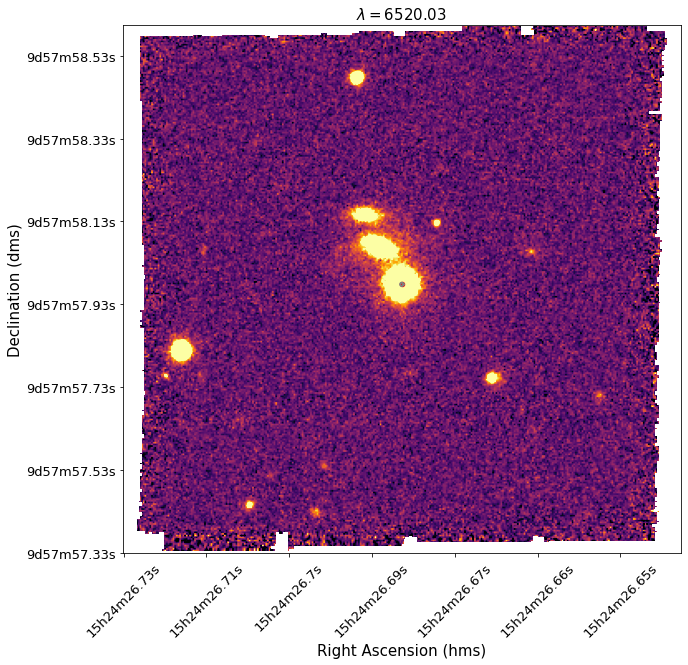

In [30]:
fig, ax = plt.subplots(1, figsize=(10,10))

ax.imshow(spec_arr, vmin = min_flux, vmax = max_flux, cmap='inferno')

ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav, 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

<ipython-input-31-5d3d8f6dce5e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
<ipython-input-31-5d3d8f6dce5e>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


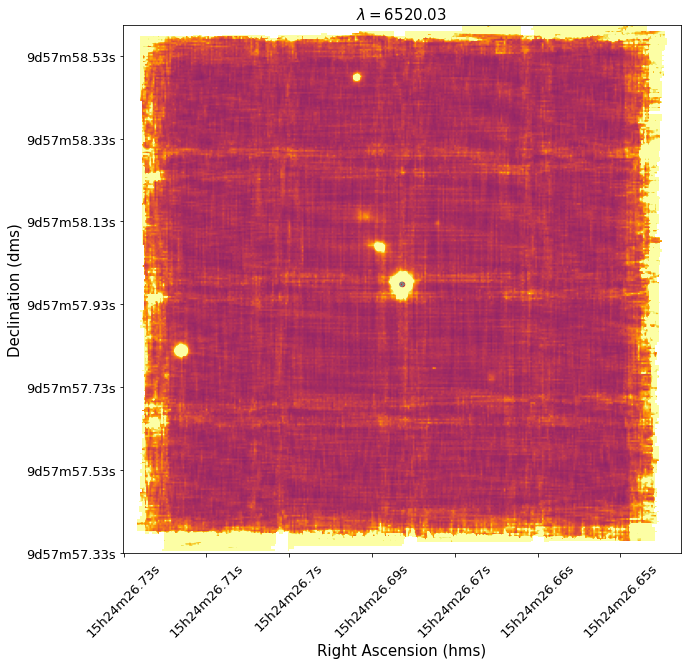

In [31]:
fig, ax = plt.subplots(1, figsize=(10,10))

ax.imshow(var_arr, vmin = min_flux, vmax = max_flux, cmap='inferno')

ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav, 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

Load in the segmentation map

In [32]:
seg_fits = fits.open(rootdir+'test_seg.fits')

In [33]:
seg_fits.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/test_seg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      42   (337, 319)   int32   


In [34]:
seg_fits[0].header

SIMPLE  =                    T                                                  
BITPIX  =                   32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  337                                                  
NAXIS2  =                  319                                                  
                                                                                
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

In [37]:
seg_map = seg_fits[0].data

Derive the segmentation map for the first galaxy

In [38]:
seg_map[qso_ref_pix_y, qso_ref_pix_x]

43

In [39]:
np.max(seg_map)

97

In [40]:
gal_1_x_pix = 155
gal_1_y_pix = 184

In [41]:
gal_1_id = seg_map[gal_1_y_pix, gal_1_x_pix]

In [42]:
gal_1_id

42

In [43]:
seg_map_gal_1_y, seg_map_gal_1_x = np.where(seg_map==gal_1_id)

<ipython-input-44-9e98adbda422>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
<ipython-input-44-9e98adbda422>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


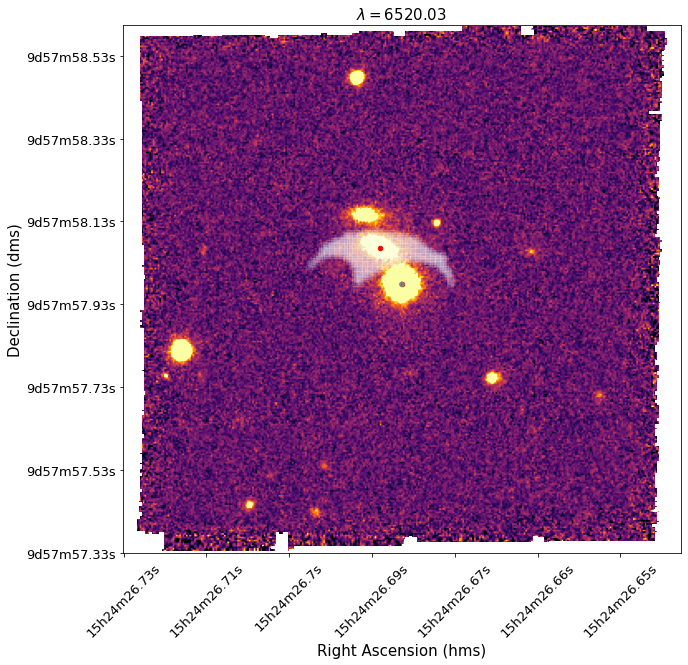

In [44]:
fig, ax = plt.subplots(1, figsize=(10,10))

ax.imshow(spec_arr, vmin = min_flux, vmax = max_flux, cmap='inferno')

ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s= 20)

ax.scatter(seg_map_gal_1_x, seg_map_gal_1_y, color='white', marker='s',alpha=.05)
ax.scatter(gal_1_x_pix, gal_1_y_pix, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav, 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

Now derive the segmentation map for the second galaxy

In [45]:
gal_2_x_pix = 146
gal_2_y_pix = 203

In [46]:
gal_2_id = seg_map[gal_2_y_pix, gal_2_x_pix]

In [47]:
gal_2_id

41

In [48]:
seg_map_gal_2_y, seg_map_gal_2_x = np.where(seg_map==gal_2_id)

<ipython-input-49-bd5ecf3fe8a4>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
<ipython-input-49-bd5ecf3fe8a4>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


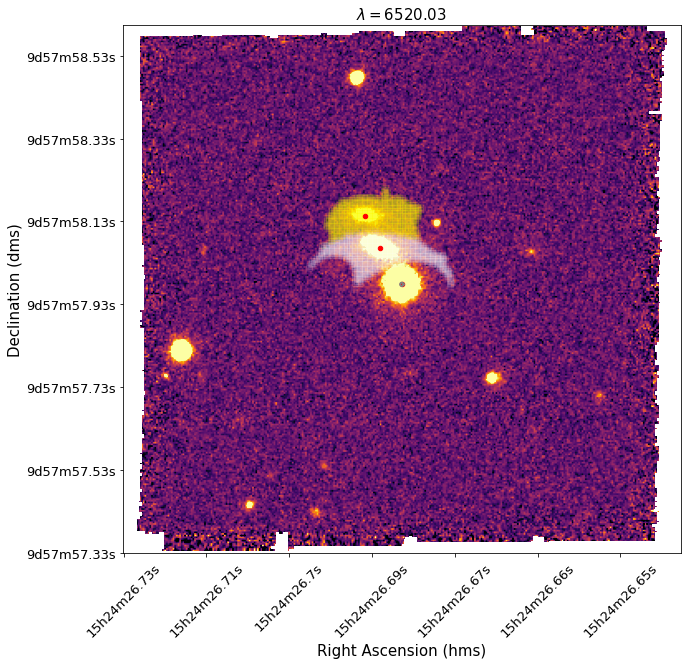

In [49]:
fig, ax = plt.subplots(1, figsize=(10,10))

ax.imshow(spec_arr, vmin = min_flux, vmax = max_flux, cmap='inferno')

ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s= 20)

ax.scatter(seg_map_gal_1_x, seg_map_gal_1_y, color='white', marker='s',alpha=.05)
ax.scatter(gal_1_x_pix, gal_1_y_pix, color='red', s= 20)

ax.scatter(seg_map_gal_2_x, seg_map_gal_2_y, color='yellow', marker='s',alpha=.05)
ax.scatter(gal_2_x_pix, gal_2_y_pix, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav, 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

Get bolometric flux distribution across the segments for each galaxy

In [41]:
flux_gal_1 = np.zeros(len(seg_map_gal_1_x))

for i in range(len(seg_map_gal_1_x)):
    
    x = seg_map_gal_1_x[i]
    y = seg_map_gal_1_y[i]
    
    flux_gal_1[i] = np.nansum(spec_cube[:,y,x])

In [42]:
flux_gal_2 = np.zeros(len(seg_map_gal_2_x))

for i in range(len(seg_map_gal_2_x)):
    
    x = seg_map_gal_2_x[i]
    y = seg_map_gal_2_y[i]
    
    flux_gal_2[i] = np.nansum(spec_cube[:,y,x])

Select only the spaxels that are in the top 90% (?) of the flux distribution

In [43]:
min_flux_gal_1 = np.nanpercentile(flux_gal_1, 65)
max_flux_gal_1 = np.nanpercentile(flux_gal_1, 100)

idx_gal_1 = (flux_gal_1>=min_flux_gal_1) & (flux_gal_1<=max_flux_gal_1)

In [44]:
min_flux_gal_2 = np.nanpercentile(flux_gal_2, 78)
max_flux_gal_2 = np.nanpercentile(flux_gal_2, 100)

idx_gal_2 = (flux_gal_2>=min_flux_gal_2) & (flux_gal_2<=max_flux_gal_2)

<ipython-input-45-9cbdfd4c24f7>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
<ipython-input-45-9cbdfd4c24f7>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


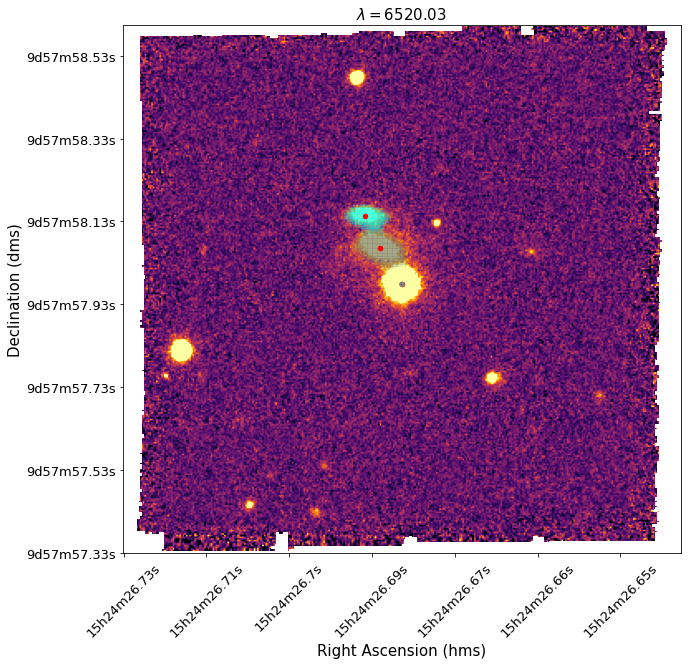

In [45]:
fig, ax = plt.subplots(1, figsize=(10,10))

ax.imshow(spec_arr, vmin = min_flux, vmax = max_flux, cmap='inferno')

ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s= 20)

ax.scatter(seg_map_gal_1_x[idx_gal_1], seg_map_gal_1_y[idx_gal_1], color='gray', marker='s',alpha=.05)
ax.scatter(gal_1_x_pix, gal_1_y_pix, color='red', s= 20)

ax.scatter(seg_map_gal_2_x[idx_gal_2], seg_map_gal_2_y[idx_gal_2], color='cyan', marker='s',alpha=.05)
ax.scatter(gal_2_x_pix, gal_2_y_pix, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav, 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

Construct master spectra for each galaxy

In [46]:
spec_stack_1 = np.zeros((len(seg_map_gal_1_x), len(wav_arr)))

for i in range(len(seg_map_gal_1_x)):
    
    x = seg_map_gal_1_x[i]
    y = seg_map_gal_1_y[i]
    
    spec_stack_1[i,:] = spec_cube[:,y,x]
    
spec_master_1 = np.nanmedian(spec_stack_1[idx_gal_1], axis=0)

In [47]:
spec_stack_2 = np.zeros((len(seg_map_gal_2_x), len(wav_arr)))

for i in range(len(seg_map_gal_2_x)):
    
    x = seg_map_gal_2_x[i]
    y = seg_map_gal_2_y[i]
    
    spec_stack_2[i,:] = spec_cube[:,y,x]
    
spec_master_2 = np.nanmedian(spec_stack_2[idx_gal_2], axis=0)

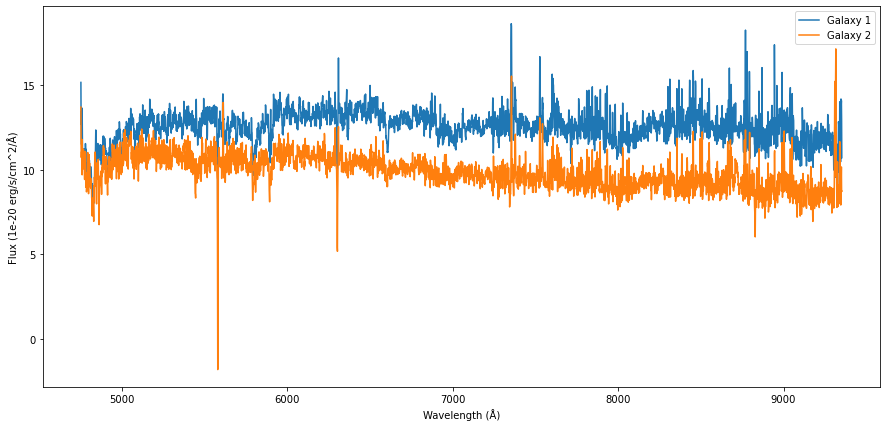

In [49]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_arr, spec_master_1, label='Galaxy 1')
ax.plot(wav_arr, spec_master_2, label='Galaxy 2')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux (1e-20 erg/s/cm^2/Å)')

#ax.set_ylim(0,7.2)

ax.legend()

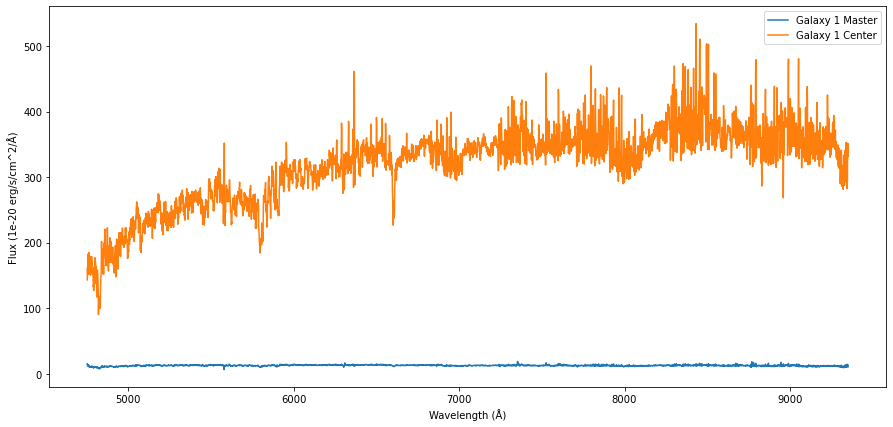

In [50]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_arr, spec_master_1, label='Galaxy 1 Master')
ax.plot(wav_arr, spec_cube[:, gal_1_y_pix, gal_1_x_pix], label='Galaxy 1 Center')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux (1e-20 erg/s/cm^2/Å)')

ax.legend()

Subtract these master spectra from all galactic spaxels

In [51]:
def scale_off(f, a, b):
    return a*f + b

In [52]:
apply_offset = True

In [53]:
a_gal_1 = []
b_gal_1 = []

for i in range(len(seg_map_gal_1_x)):
    
    x = seg_map_gal_1_x[i]
    y = seg_map_gal_1_y[i]
    
    f = spec_cube[:,y,x]
    
    idx = ~(np.isnan(f) | np.isnan(spec_master_1))
    
    if(apply_offset == True):
        opt, covar = curve_fit(scale_off, spec_master_1[idx], f[idx])
        b_gal_1.append(opt[1])
    else:
        opt, covar = curve_fit(lambda f, a: scale_off(f, a, 0), spec_master_1[idx], f[idx])
        b_gal_1.append(0)
    
    a_gal_1.append(opt[0])

In [54]:
a_gal_2 = []
b_gal_2 = []

for i in range(len(seg_map_gal_2_x)):
    
    x = seg_map_gal_2_x[i]
    y = seg_map_gal_2_y[i]
    
    f = spec_cube[:,y,x]
    
    idx = ~(np.isnan(f) | np.isnan(spec_master_2))
    
    if(apply_offset == True):
        opt, covar = curve_fit(scale_off, spec_master_2[idx], f[idx])
        b_gal_2.append(opt[1])
    else:
        opt, covar = curve_fit(lambda f, a: scale_off(f, a, 0), spec_master_2[idx], f[idx])
        b_gal_2.append(0)
    
    a_gal_2.append(opt[0])

In [55]:
spec_cube_sub = data_hdu.data.copy()

In [56]:
for i in range(len(seg_map_gal_1_x)):
    
    x = seg_map_gal_1_x[i]
    y = seg_map_gal_1_y[i]
    
    spec_cube_sub[:,y,x] -= a_gal_1[i]*spec_master_1+b_gal_1[i]

In [57]:
for i in range(len(seg_map_gal_2_x)):
    
    x = seg_map_gal_2_x[i]
    y = seg_map_gal_2_y[i]
    
    spec_cube_sub[:,y,x] -= a_gal_2[i]*spec_master_2+b_gal_2[i]

In [58]:
wav_slice_idx = np.arange(0, len(wav_arr), 500)
wav_slice = wav_arr[wav_slice_idx]

<ipython-input-59-7ab3b57cf6a4>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels[qso_ref_pix_x-qso_window_pix:qso_ref_pix_x+qso_window_pix],
<ipython-input-59-7ab3b57cf6a4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels[qso_ref_pix_x-qso_window_pix:qso_ref_pix_x+qso_window_pix], fontsize=13)


Text(0, 1, 'Declination (dms)')

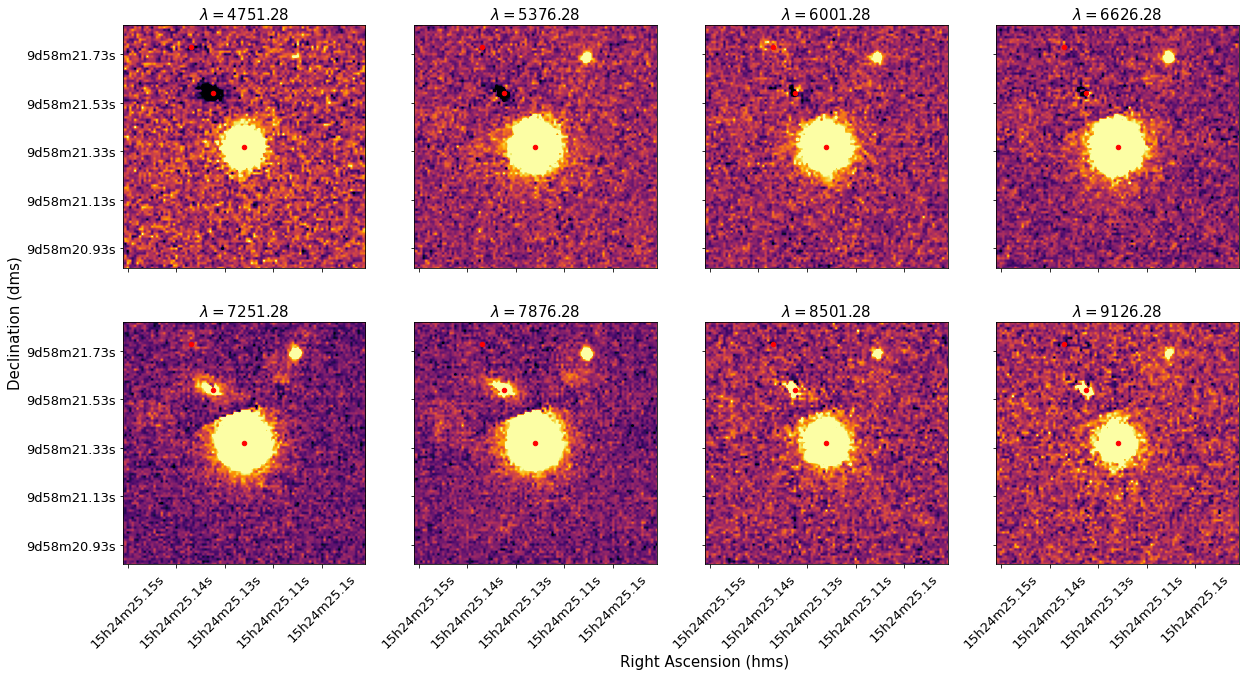

In [59]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex = True, sharey=True)

for i in range(len(wav_slice)):
    wav_idx = wav_slice_idx[i]
    wav = wav_slice[i]
    ax = axes[i//4][i%4]
    
    qso_window_pix = 50
    
    spec_arr_sub = spec_cube_sub[wav_idx,:,:]
    
    spec_arr_sub_flat = spec_arr_sub.flatten()
    min_flux_sub = np.nanpercentile(spec_arr_sub_flat, 1)
    max_flux_sub = np.nanpercentile(spec_arr_sub_flat, 99)

    ax.imshow(spec_arr_sub, vmin = min_flux_sub, vmax = max_flux_sub, cmap='inferno')

    ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s=20)
    ax.scatter(gal_1_x_pix, gal_1_y_pix, color='red', s= 20)
    ax.scatter(gal_2_x_pix, gal_2_y_pix, color='red', s= 20)


    ax.set_title(r'$\lambda = $' + str(np.round(wav, 2)), fontsize=15)
    ax.set_xticklabels(RA_arr_labels[qso_ref_pix_x-qso_window_pix:qso_ref_pix_x+qso_window_pix], 
                       rotation=45, fontsize=13)
    ax.set_yticklabels(Dec_arr_labels[qso_ref_pix_x-qso_window_pix:qso_ref_pix_x+qso_window_pix], fontsize=13)


    ax.set_xlim(qso_ref_pix_x-qso_window_pix, qso_ref_pix_x+qso_window_pix)
    ax.set_ylim(qso_ref_pix_y+qso_window_pix, qso_ref_pix_y-qso_window_pix)

    ax.invert_yaxis()
    
axes[1,2].set_xlabel('Right Ascension (hms)', fontsize=15, position=(0,1))
axes[1,0].set_ylabel('Declination (dms)', fontsize=15, position=(0,1))